In [509]:
from math import sqrt
from sklearn.cross_validation import train_test_split
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import to_datetime
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import load_model
from matplotlib import pyplot

In [510]:
# Start of helper functions

In [515]:
# Converting time series data to Supervised

def convertTimeSeriesToLSTM(inputData):
    DF = DataFrame(inputData)
    prepData = list()
    prepData.append(DF.shift(1))
    prepData.append(DF.shift(-1))
    lstmData = concat(prepData, axis= 1)
    # print(lstmData[:10])
    lstmData.dropna(inplace=True)
    # print(lstmData[:10])
    return lstmData

In [512]:
# End of helper functions

In [513]:
#datasetFull = read_csv('./data/house5/channel_5TV.dat_OnOFF_FULL.csv', sep=',') #names=['Index','Timestamp','Usage','Date','Year','Month','Day','Hour','Minute','Second'])
#datasetFull = datasetFull[:10000] #
#ndataset = datasetFull.drop(['Index', 'Timestamp', 'Date', 'Year'], axis = 1)
#dataset = ndataset[['Month', 'Day', 'Hour', 'Minute', 'Second', 'Usage']]
#values = dataset.values

In [383]:
file_read = read_csv('./data/house5/channel_5TV.dat', sep=' ', names=['Timestamp', 'Usage']) #names=['Index','Timestamp','Usage','Date','Year','Month','Day','Hour','Minute','Second'])
file_read['Timestamp'] = to_datetime(file_read['Timestamp'],unit='s')
file_read['Date'] = file_read['Timestamp'].dt.date
file_read['Year'] = file_read['Timestamp'].dt.year
file_read['Month'] = file_read['Timestamp'].dt.month
file_read['Day'] = file_read['Timestamp'].dt.day
file_read['Hour'] = file_read['Timestamp'].dt.hour
file_read['Minute'] = file_read['Timestamp'].dt.minute
file_read['Second'] = file_read['Timestamp'].dt.second

datasetFull = file_read
ndataset = datasetFull.drop(['Timestamp', 'Date', 'Year'], axis = 1)
dataset = ndataset[['Month', 'Day', 'Hour', 'Minute', 'Second', 'Usage']]


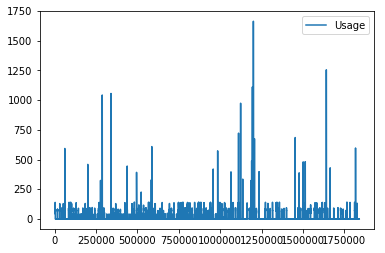

In [384]:
# graph for Usage
pyplot.plot(dataset['Usage'], label='Usage')
pyplot.legend()
pyplot.show()

In [385]:
#print(dataset[:5])
#scaler = MaxAbsScaler()
#scaled = scaler.fit_transform(dataset[:5])
#print(scaled)
#print(max(dataset['Month']), min(dataset['Month']), max(dataset['Usage']), min(dataset['Usage']))

11 6 1664 0


In [386]:
# Normalizing features
from numpy import transpose
def normalizeTable(data, maxUsage = -1):
    data[0] = data[0] / 12  # Change to 12
    data[1] = data[1] / 31
    data[2] = data[2] / 24
    data[3] = data[3] / 60
    data[4] = data[4] / 60
    if maxUsage != -1:
        data[5] = data[5] / maxUsage
    return data

def normalizeData(values, maxUsage=-1):
    transposed = transpose(values)
    scaledT = normalizeTable(transposed, maxUsage)
    scaled = transpose(scaledT)
    return scaled

values = dataset.astype(float).values
maxUsage = max(dataset['Usage'])
scaled = normalizeData(values, maxUsage)


In [387]:
# Convert data to the format appropriate for LSTM 
lstmData = convertTimeSeriesToLSTM(scaled)

In [388]:
values = lstmData.values
print(values.shape)


(1840506, 12)


In [389]:
#print(values)

In [390]:
# Separate input and output data
values = lstmData.values
X = values[:,:5]
Y = values[:,5]

#print(Y)
# Splitting data into train, validation adn test set
X_Train, X_Temp, Y_Train, Y_Temp = train_test_split(X, Y, test_size=0.4)
X_Valid, X_Test, Y_Valid, Y_Test = train_test_split(X_Temp, Y_Temp, test_size =0.2)

# Reshape input to be 3D for LSTM input[samples, timesteps, features]
X_Train = X_Train.reshape((X_Train.shape[0], 1, X_Train.shape[1]))
X_Valid = X_Valid.reshape((X_Valid.shape[0], 1, X_Valid.shape[1]))
X_Test = X_Test.reshape((X_Test.shape[0], 1, X_Test.shape[1]))

In [391]:
#print (X_Train)
#print(Y_Train)

In [392]:
# network architecture
model = Sequential()
model.add(LSTM(50, input_shape=(X_Train.shape[1], X_Train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit
history = model.fit(X_Train, Y_Train, epochs=5, batch_size=10, validation_data=(X_Valid, Y_Valid), verbose=2, shuffle=False)

Train on 1104303 samples, validate on 588962 samples
Epoch 1/5
342s - loss: 1.1116e-04 - val_loss: 1.0241e-04
Epoch 2/5
331s - loss: 1.0127e-04 - val_loss: 1.0130e-04
Epoch 3/5
333s - loss: 1.0023e-04 - val_loss: 1.0019e-04
Epoch 4/5
379s - loss: 9.9733e-05 - val_loss: 1.0012e-04
Epoch 5/5
436s - loss: 9.9464e-05 - val_loss: 9.9685e-05


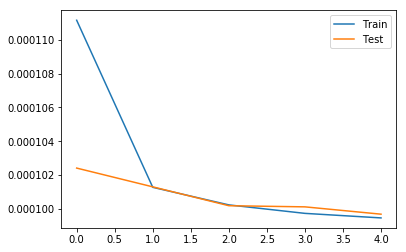

In [394]:
# plot history

pyplot.plot(history.history['loss'], label='Train')
pyplot.plot(history.history['val_loss'], label='Test')
pyplot.legend()
pyplot.show()

In [395]:
print(Y_Test.shape, Y_Test.shape)

(147241,) (147241,)


In [396]:
# Predict for Test data
prediction = model.predict(X_Test)
Y_Test = Y_Test.reshape(Y_Test.shape[0],-1)

In [397]:
Diff = Y_Test - prediction

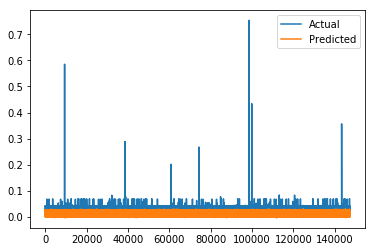

In [398]:
pyplot.plot(Y_Test, label='Actual')
pyplot.plot(prediction, label='Predicted')
pyplot.legend()
pyplot.show()

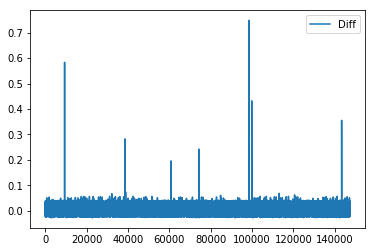

In [400]:
pyplot.plot(Diff, label='Diff')
pyplot.legend()
pyplot.show()

In [401]:
print(mean_squared_error(Y_Test, prediction))

0.00010714595446


In [402]:
#from numpy import concatenate
#print(prediction.shape, Y_Test.shape)
#compareAns = concatenate((prediction, Y_Test), axis=0)
#print(prediction[:10])
#print(Y_Test[:10])

In [514]:
# Save model on system
model.save('savedModels/full_TV.h5')

In [189]:
model = load_model('full_data_h5_c5.h5')

In [504]:
def predictOnNext3Hours(s):
    from datetime import datetime

    timeS = datetime.fromtimestamp(float(s))
    print(timeS)
    timeList = []
    
    for i in range(0,180):
        tList = [7, timeS.day, timeS.hour+ int(i/60), timeS.minute + i % 60, timeS.second]
        timeList.append(tList)
    newData1 = DataFrame(timeList)
    newData = normalizeData(newData1.astype(float).values)
    pData = newData.reshape((newData.shape[0], 1, newData.shape[1]))
    prediction = model.predict(pData)
    usageValues = prediction * max(dataset['Usage'])
    # print(prediction[:10])
    #print(usageValues)
    return usageValues

def predictForSingleTime(s):
    timeS = datetime.fromtimestamp(float(s))
    print(timeS)
    timeList = []
    tList = [7, timeS.day, timeS.hour, timeS.minute, timeS.second]
    timeList.append(tList)
    newData1 = DataFrame(timeList)
    newData = normalizeData(newData1.astype(float).values)
    pData = newData.reshape((newData.shape[0], 1, newData.shape[1]))
    prediction = model.predict(pData)
    usageValues = prediction * max(dataset['Usage'])
    #print(usageValues[0][0])
    return isOnOrOff(usageValues[0][0]) 
    
# UNCOMMENT APPROPRIATE DEVICE BELOW
# NOTE THAT THIS SHOULD BE REPLACED BY THRESHOLD 
# BEING COMPUTED FROM TRAINING DATA
#applianceUsed = 'MICROWAVE'
applianceUsed = 'TV'

def getThresholdValue():
    if (applianceUsed == 'TV'):
        return 1
    elif (applianceUsed == 'MICROWAVE'):
        return 2
    # UNKNOWN DEVICE 
    return 1
    
def isOnOrOff(usageValue):
    threshold = getThresholdValue()
    if (usageValue > threshold):
        return True
    return False
        


In [501]:
# standBy = dataset['Usage'].value_counts()
# print(standBy)

2017-07-06 13:00:00


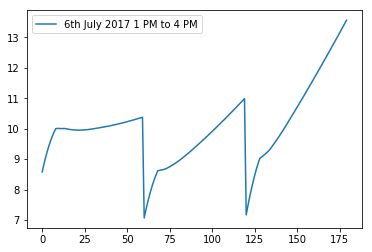

In [487]:
usage = predictOnNext3Hours("1499360400")
pyplot.plot(usage, label = "6th July 2017 1 PM to 4 PM")
pyplot.legend()
pyplot.show()

2017-07-06 16:00:00


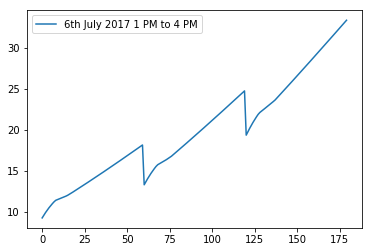

In [480]:
usage = predictOnNext3Hours("1499371200")
pyplot.plot(usage, label = "6th July 2017 4 PM to 7 PM")
pyplot.legend()
pyplot.show()

2017-07-06 19:00:00


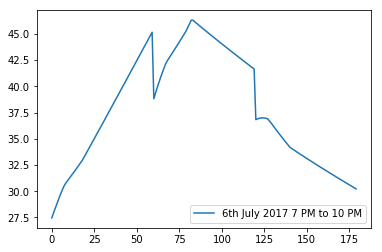

In [483]:
usage = predictOnNext3Hours("1499382000")
pyplot.plot(usage, label = "6th July 2017 7 PM to 10 PM")
pyplot.legend()
pyplot.show()

In [505]:
print(predictForSingleTime("1499382000"))

2017-07-06 19:00:00
27.4528
True
